In [1]:
import sys
import numpy as np
from collections import defaultdict
import matlab.engine
import time
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
np.random.seed()

In [2]:
EPSILON = 0.0001
 
FAIRLETS = []
FAIRLET_CENTERS = []
 
class TreeNode:
 
    def __init__(self):
        self.children = []
 
    def set_cluster(self, cluster):
        self.cluster = cluster
 
    def add_child(self, child):
        self.children.append(child)
 
    def populate_colors(self, colors):
        "Populate auxiliary lists of red and blue points for each node, bottom-up"
        self.reds = []
        self.blues = []
        if len(self.children) == 0:
            # Leaf
            for i in self.cluster:
                if colors[i] == 0:
                    self.reds.append(i)
                else:
                    self.blues.append(i)
        else:
            # Not a leaf
            for child in self.children:
                child.populate_colors(colors)
                self.reds.extend(child.reds)
                self.blues.extend(child.blues)
 
 

In [3]:

### K-MEDIAN CODE ###
 
def kmedian_cost(points, centroids, dataset):
    "Computes and returns k-median cost for given dataset and centroids"
    return sum(np.amin(np.concatenate([np.linalg.norm(dataset[:,:]-dataset[centroid,:], axis=1).reshape((dataset.shape[0], 1)) for centroid in centroids], axis=1), axis=1))


In [4]:

def fair_kmedian_cost(centroids, dataset):
    "Return the fair k-median cost for given centroids and fairlet decomposition"
    total_cost = 0
    for i in range(len(FAIRLETS)):
        # Choose index of centroid which is closest to the i-th fairlet center
        cost_list = [np.linalg.norm(dataset[centroids[j],:]-dataset[FAIRLET_CENTERS[i],:]) for j in range(len(centroids))]
        cost, j = min((cost, j) for (j, cost) in enumerate(cost_list))
        # Assign all points in i-th fairlet to above centroid and compute cost
        total_cost += sum([np.linalg.norm(dataset[centroids[j],:]-dataset[point,:]) for point in FAIRLETS[i]])
    return total_cost
 

In [5]:

 
### FAIRLET DECOMPOSITION CODE ###
 
def balanced(p, q, r, b):
    if r==0 and b==0:
        return True
    if r==0 or b==0:
        return False
    return min(r*1./b, b*1./r) >= p*1./q
 
 

In [6]:

def make_fairlet(points, dataset):
    "Adds fairlet to fairlet decomposition, returns median cost"
    FAIRLETS.append(points)
   # print(dataset)
    cost_list = [sum([np.linalg.norm(dataset[center,:]-dataset[point,:]) for point in points]) for center in points]
    cost, center = min((cost, center) for (center, cost) in enumerate(cost_list))
    FAIRLET_CENTERS.append(points[center])
    return cost
 

In [7]:

 
def basic_fairlet_decomposition(p, q, blues, reds, dataset):
    """
    Computes vanilla (p,q)-fairlet decomposition of given points (Lemma 3 in NIPS17 paper).
    Returns cost.
    Input: Balance parameters p,q which are non-negative integers satisfying p<=q and gcd(p,q)=1.
    "blues" and "reds" are sets of points indices with balance at least p/q.
    """
    assert p <= q, "Please use balance parameters in the correct order"
    if len(reds) < len(blues):
        temp = blues
        blues = reds
        reds = temp
    R = len(reds)
    B = len(blues)
    assert balanced(p, q, R, B), "Input sets are unbalanced: "+str(R)+","+str(B)
 
    if R==0 and B==0:
        return 0
 
    b0 = 0
    r0 = 0
    cost = 0
    while (R-r0)-(B-b0) >= q-p and R-r0 >= q and B-b0 >= p:
        cost += make_fairlet(reds[r0:r0+q]+blues[b0:b0+p], dataset)
        r0 += q
        b0 += p
    if R-r0 + B-b0 >=1 and R-r0 + B-b0 <= p+q:
        cost += make_fairlet(reds[r0:]+blues[b0:], dataset)
        r0 = R
        b0 = B
    elif R-r0 != B-b0 and B-b0 >= p:
        cost += make_fairlet(reds[r0:r0+(R-r0)-(B-b0)+p]+blues[b0:b0+p], dataset)
        r0 += (R-r0)-(B-b0)+p
        b0 += p
    assert R-r0 == B-b0, "Error in computing fairlet decomposition"
    for i in range(R-r0):
        cost += make_fairlet([reds[r0+i], blues[b0+i]], dataset)
    return cost
 
 

In [8]:

def node_fairlet_decomposition(p, q, node, dataset, donelist, depth):

    # Leaf                                                                                          
    if len(node.children) == 0:
        node.reds = [i for i in node.reds if donelist[i]==0]
        node.blues = [i for i in node.blues if donelist[i]==0]
        assert balanced(p, q, len(node.reds), len(node.blues)), "Reached unbalanced leaf"
        return basic_fairlet_decomposition(p, q, node.blues, node.reds, dataset)
 
    # Preprocess children nodes to get rid of points that have already been clustered
    for child in node.children:
        child.reds = [i for i in child.reds if donelist[i]==0]
        child.blues = [i for i in child.blues if donelist[i]==0]
 
    R = [len(child.reds) for child in node.children]
    B = [len(child.blues) for child in node.children]
 
    if sum(R) == 0 or sum(B) == 0:
        assert sum(R)==0 and sum(B)==0, "One color class became empty for this node while the other did not"
        return 0
 
    NR = 0
    NB = 0
 
    # Phase 1: Add must-remove nodes
    for i in range(len(node.children)):
        if R[i] >= B[i]:
            must_remove_red = max(0, R[i] - int(np.floor(B[i]*q*1./p)))
            R[i] -= must_remove_red
            NR += must_remove_red
        else:
            must_remove_blue = max(0, B[i] - int(np.floor(R[i]*q*1./p)))
            B[i] -= must_remove_blue
            NB += must_remove_blue
 
    # Calculate how many points need to be added to smaller class until balance
    if NR >= NB:
        # Number of missing blues in (NR,NB)
        missing = max(0, int(np.ceil(NR*p*1./q)) - NB)
    else:
        # Number of missing reds in (NR,NB)
        missing = max(0, int(np.ceil(NB*p*1./q)) - NR)
         
    # Phase 2: Add may-remove nodes until (NR,NB) is balanced or until no more such nodes
    for i in range(len(node.children)):
        if missing == 0:
            assert balanced(p, q, NR, NB), "Something went wrong"
            break
        if NR >= NB:
            may_remove_blue = B[i] - int(np.ceil(R[i]*p*1./q))
            remove_blue = min(may_remove_blue, missing)
            B[i] -= remove_blue
            NB += remove_blue
            missing -= remove_blue
        else:
            may_remove_red = R[i] - int(np.ceil(B[i]*p*1./q))
            remove_red = min(may_remove_red, missing)
            R[i] -= remove_red
            NR += remove_red
            missing -= remove_red
 
    # Phase 3: Add unsatuated fairlets until (NR,NB) is balanced
    for i in range(len(node.children)):
        if balanced(p, q, NR, NB):
            break
        if R[i] >= B[i]:
            num_saturated_fairlets = int(R[i]/q)
            excess_red = R[i] - q*num_saturated_fairlets
            excess_blue = B[i] - p*num_saturated_fairlets
        else:
            num_saturated_fairlets = int(B[i]/q)
            excess_red = R[i] - p*num_saturated_fairlets
            excess_blue = B[i] - q*num_saturated_fairlets
        R[i] -= excess_red
        NR += excess_red
        B[i] -= excess_blue
        NB += excess_blue
 
    assert balanced(p, q, NR, NB), "Constructed node sets are unbalanced"
 
    reds = []
    blues = []
    for i in range(len(node.children)):
        for j in node.children[i].reds[R[i]:]:
            reds.append(j)
            donelist[j] = 1
        for j in node.children[i].blues[B[i]:]:
            blues.append(j)
            donelist[j] = 1
 
    assert len(reds)==NR and len(blues)==NB, "Something went horribly wrong"
 
    return basic_fairlet_decomposition(p, q, blues, reds, dataset) + sum([node_fairlet_decomposition(p, q, child, dataset, donelist, depth+1) for child in node.children])
 

In [9]:

 
def tree_fairlet_decomposition(p, q, root, dataset, colors):
    "Main fairlet clustering function, returns cost wrt original metric (not tree metric)"
    assert p <= q, "Please use balance parameters in the correct order"
    root.populate_colors(colors)
    assert balanced(p, q, len(root.reds), len(root.blues)), "Dataset is unbalanced"
    root.populate_colors(colors)
    donelist = [0] * dataset.shape[0]
    return node_fairlet_decomposition(p, q, root, dataset, donelist, 0)
 
 

In [10]:

### QUADTREE CODE ###
 
def build_quadtree(dataset, max_levels=0, random_shift=True):
    "If max_levels=0 there no level limit, quadtree will partition until all clusters are singletons"
    dimension = dataset.shape[1]
    lower = np.amin(dataset, axis=0)
    upper = np.amax(dataset, axis=0)
 
    shift = np.zeros(dimension)
    if random_shift:
        for d in range(dimension):
            spread = upper[d] - lower[d]
            shift[d] = np.random.uniform(0, spread)
            upper[d] += spread
 
    return build_quadtree_aux(dataset, range(dataset.shape[0]), lower, upper, max_levels, shift)
     
 

In [11]:

def build_quadtree_aux(dataset, cluster, lower, upper, max_levels, shift):
    """
    "lower" is the "bottom-left" (in all dimensions) corner of current hypercube
    "upper" is the "upper-right" (in all dimensions) corner of current hypercube
    """
 
    dimension = dataset.shape[1]
    cell_too_small = True
    for i in range(dimension):
        if upper[i]-lower[i] > EPSILON:
            cell_too_small = False
 
    node = TreeNode()
    if max_levels==1 or len(cluster)<=1 or cell_too_small:
        # Leaf
        node.set_cluster(cluster)
        return node
     
    # Non-leaf
    midpoint = 0.5 * (lower + upper)
    subclusters = defaultdict(list)
    for i in cluster:
        subclusters[tuple([dataset[i,d]+shift[d]<=midpoint[d] for d in range(dimension)])].append(i)
    for edge, subcluster in subclusters.items():
        sub_lower = np.zeros(dimension)
        sub_upper = np.zeros(dimension)
        for d in range(dimension):
            if edge[d]:
                sub_lower[d] = lower[d]
                sub_upper[d] = midpoint[d]
            else:
                sub_lower[d] = midpoint[d]
                sub_upper[d] = upper[d]
        node.add_child(build_quadtree_aux(dataset, subcluster, sub_lower, sub_upper, max_levels-1, shift))
    return node
 
 

**DIABETES DATASET PREPROCESSING** 

In [20]:

def load_diabetes(data_dir=''):

   # data_dir = 'PycharmProjects/Fair_clustering_EF1/Datasets_minor/'

    _path = 'diabetic_data.csv'
    data_path = os.path.join(data_dir, _path)
  
    df = pd.read_csv(data_path, sep=',', header=[0])
    n = df.shape[0]
    #print(df.head())
    df = df.iloc[:,[3,4,9]]
    age_ = []
    gender_ =[]
    for index, row in df.iterrows():
        s = row['age']
        s = s[1:-1]
        a,b= s.split("-")
        age_.append((int(a)+int(b))//2);
        
        if row['gender']=='Female':
            gender_.append(1)
        else:
            gender_.append(0)
            
        
    df['age']=age_;
   # df['gender']=gender_;
    df=df.drop(4)
    #print(df.head())
    df=df.iloc[:,[1,2]]
        
    return  df.to_numpy(), np.array(gender_)

#load_diabetes()



**BANK DATASET PREPROCESSING** 

*Step 1: Data Preprocessing* 

In [13]:

def load_bank(data_dir=''):

    data_dir = 'PycharmProjects/Fair_clustering_EF1/Datasets_minor/'
    _path = 'bank.csv'
    data_path = os.path.join(data_dir, _path)
      
    df = pd.read_csv(data_path, sep=',', header=[0])
    df1 = df.loc[df['marital'] == 'married']
    df2 = df.loc[df['marital'] == 'single']
   # df3 = df.loc[df['marital'] =='divorced']
    
    
    df = [df1, df2]#, df3]
    df = pd.concat(df)
    n = df.shape[0]
    
    sex = df['marital']
    sens_attributes = list(set(sex.astype(str).values))  # =[' Female', ' Male']
    sex_num = np.zeros(n, dtype=int)
    sex_num[sex.astype(str).values == sens_attributes[1]] = 1  #female ko 1 set

    df = df.iloc[:, [0,5,11]]
    return  df.to_numpy(),sex_num
   
#load_bank()



**CENSUS DATASET PREPROCESSING** 

*Step 1: Data Preprocessing* 

In [14]:

def load_census(data_dir=''):

    data_dir = 'PycharmProjects/Fair_clustering_EF1/Datasets_minor/'
    _path = 'adult.data'
    data_path = os.path.join(data_dir, _path)

    df = pd.read_csv(data_path, sep=',', header=None)
    n = df.shape[0]
    
    df = df.iloc[:, [9,0,12,2,4,10]]
    
    sex = df[9]
    sens_attributes = list(set(sex.astype(str).values))  # =[' Female', ' Male']
    sex_num = np.zeros(n, dtype=int)
    sex_num[sex.astype(str).values == sens_attributes[1]] = 1  #female ko 1 set

   
   # df['gen']= sex_num
    df = df.iloc[:, [1,2,3,4,5]]
        
    
   
    return  df.to_numpy(),sex_num

#load_census()


**CENSUS II DATASET PREPROCESSING** 

*Step 1: Data Preprocessing* 

In [15]:
 
def load_censusII(data_dir=''):

    data_dir = 'PycharmProjects/Fair_clustering_EF1/Datasets_minor/'
    _path = 'USCensus1990raw.data.txt'
    data_path = os.path.join(data_dir, _path)

    df = pd.read_csv(data_path, sep='\t', header=None)
    n = df.shape[0]
    sex_num = df.iloc[:, 112].astype(int)

    selected_attributes = [12, 35, 36, 47, 53, 54, 55, 58, 60, 63, 64, 65, 73, 80, 81, 93, 94, 95, 96, 101, 109, 116,
                           118, 122, 124]

    
  
    df = df.iloc[:,selected_attributes]

    #df['type'] = sex_num
    
    #df = df.iloc[:,[25,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
    return df.to_numpy(), sex_num.to_numpy()

#load_censusII()

**Loading, Fairlet decomposition & clustering**

In [16]:
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

In [17]:
def load_dataset(dataset_name):
    if dataset_name=='diabetes':
        dataset,colors_ = load_diabetes()
    elif dataset_name=='census':
        dataset,colors_ = load_census()
    elif dataset_name=='censusII':
        dataset,colors_ = load_censusII()
    elif dataset_name=='bank':
        dataset,colors_ = load_bank()
    else:
        print('Using Randomised dataset')
        n_points = 1000
        dimension = 5
        dataset = np.random.random((n_points, dimension))
        colors_ = [np.random.randint(2) for i in range(n_points)]

    return dataset,colors_

In [18]:

def compute(p,q,k,dataset,colors_,sample_size,subSample):
    
    
    p = min(p,q)
    q = max(p,q)
    
    n_points = len(dataset)
    
    if  subSample==False:
        idx = np.arange(n_points)
        np.random.shuffle(idx)
        sample_size=n_points
        idx = idx[:sample_size]
        n_points = sample_size
        dataset = dataset[idx,:]
        colors = [colors_[i] for i in idx]
    else:
        iter =10
        temp = len(dataset)
        temp_dataset = dataset
        while iter>=0:
            n_points = temp
            dataset = temp_dataset
            idx = np.arange(n_points)
            random.shuffle(idx)
            random.shuffle(idx)
            random.shuffle(idx)
            random.shuffle(idx)
            #print(random.random())
                      
            idx = idx[:sample_size]
           # print(idx)
            n_points = sample_size
            dataset = dataset[idx,:]
            colors = [colors_[i] for i in idx]
            a = len([ 1 for x in colors if x==1])
            b = len([ 1 for x in colors if x==0])
           # print('a '+str(a))
           # print('b '+str(b))
            c1 = a/b
            c2 = b/a
            t1 = truncate(c1,1)
            t2 = truncate(c2,1)
            t = min(t1,t2)
            tt = truncate(p/q,1)
            if t == tt:
                break
            else: 
                #print('Sampling again')
                #import time  as timr
                #timr.sleep(30) 
                iter = iter-1

    dimension = dataset[0].shape
    #print(dataset.shape)
    #print(len(colors))
    a = [ 1 for x in colors if x==1]
    b = [ 1 for x in colors if x==0]
  #  print("A "+str(len(a)))
   # print("B "+str(len(b)))
    
  #  print("Number of data points:", n_points)
   # print("Dimension:", dimension)
   # print("Balance:", p, q)

    #print("Constructing tree...")
    fairlet_s = time.time()
    root = build_quadtree(dataset)

    #print("Doing fair clustering...")
  #  print('Beofe = '+str(dataset.shape))
   # print(dataset)
    cost = tree_fairlet_decomposition(p, q, root, dataset, colors)
    fairlet_e = time.time()

    #print("Fairlet decomposition cost:", cost)
    fairlet_time = fairlet_e-fairlet_s;
    #print("Fairlet Decomposition Runtime: ", str(fairlet_time));
    #print("Doing k-median clustering on fairlet centers...")
    fairlet_center_idx = [dataset[index] for index in FAIRLET_CENTERS]
    fairlet_center_pt = np.array([np.array(xi) for xi in fairlet_center_idx])

    # convert points into matlab array format
    mat_matrix = matlab.double(fairlet_center_pt.tolist())

    # Run k-mediod code in Matlab
    cluster_s = time.time()
    eng = matlab.engine.start_matlab()
    # C: Cluster medoid locations, returned as
    # a numeric matrix.
    # C is a k-by-d matrix, where row j is the medoid of cluster j
    #
    # midx: Index to mat_matrix, returned as a column vector of indices.
    # midx is a k-by-1 vector and the indices satisfy C = X(midx,:)
    idx,C,sumd,D,midx,info = eng.kmedoids(mat_matrix,k,'Distance','euclidean', nargout=6)
    cluster_e = time.time()
    np_idx = (np.array(idx._data)).flatten()
    total_runtime = (fairlet_e-fairlet_s) + (cluster_e-cluster_s)
    
    #print("Total Runtime: ", str(total_runtime));

    # compute the indices of centers returned by Matlab in its input matrix
    # which is mat_matrix or fairlet_center_pt
    np_midx = (np.array(midx._data)).flatten()
    c_idx_matrix = np_midx.astype(int)
    #in matlab, arrays are numbered from 1
    c_idx_matrix[:] = [index - 1 for index in c_idx_matrix]

    # indices of center points in dataset
    centroids = [FAIRLET_CENTERS[index] for index in c_idx_matrix]

    #print("Computing fair k-median cost...")
    kmedian_cost = fair_kmedian_cost(centroids, dataset)
    #print("Fairlet decomposition cost:", cost)
    #print("k-Median cost:", kmedian_cost)
    
    return kmedian_cost,cost, fairlet_time, total_runtime

    

Collecting Analytics for different sample size 

In [21]:
kmed=[]
fcost=[]
fTime=[]
tTime=[]
iter_no =[]

p = 3
q = 5
k =20
step_size = 1000
dataset, colors_ = load_dataset('diabetes')


total_size = len(dataset)

for sample_size in range(1000,1001, step_size):
    #Subsample each sample size 10 times to find average for that value
    
    for i in range(0,1000):
        print('Iteration No : '+str(i))
       # print("***************---iteration: " +str(i)+"  -----******************")
        FAIRLETS.clear()
        FAIRLET_CENTERS.clear()
        kmedian_cost,cost, fairlet_time, total_runtime = compute(p,q,k,dataset,colors_,sample_size,True)
        kmed.append(kmedian_cost)
        fcost.append(cost)
        fTime.append(fairlet_time)
        tTime.append(total_runtime)
        iter_no.append(i)
        print('Fairlet Decomposition Cost '+str((cost)))
        print('K-median Cost '+str((kmedian_cost)))
        print('Fairlet Decomposition RunTime '+str((fairlet_time)))
        print('Total RunTime '+str((total_runtime)))
        print("*************************************************************\n")

    kmed=np.array(kmed)
    fcost = np.array(fcost)
    fTime=np.array(fTime)
    tTime=np.array(tTime)
    iter_no = np.array(iter_no)
    print("Overall Results for 1000 Iteration: \n")
    print('Fairlet Decomposition Cost '+str(np.average(fcost)))
    print('K-median Cost '+str(np.average(kmed)))
    print('Fairlet Decomposition RunTime '+str(np.average(fTime)))
    print('Total RunTime '+str(np.average(tTime)))
    print("*************************************************************\n")



Iteration No : 0
Fairlet Decomposition Cost 1106.6678237888918
K-median Cost 1855.6064940927479
Fairlet Decomposition RunTime 0.3173365592956543
Total RunTime 9.359686851501465
*************************************************************

Iteration No : 1
Fairlet Decomposition Cost 791.9226594102132
K-median Cost 1550.523767431937
Fairlet Decomposition RunTime 0.21010327339172363
Total RunTime 8.50027346611023
*************************************************************

Iteration No : 2
Fairlet Decomposition Cost 531.006853749094
K-median Cost 1344.2079210585105
Fairlet Decomposition RunTime 0.16055774688720703
Total RunTime 14.030877113342285
*************************************************************

Iteration No : 3
Fairlet Decomposition Cost 733.2383665971637
K-median Cost 1521.2083936626445
Fairlet Decomposition RunTime 0.16809964179992676
Total RunTime 8.930181741714478
*************************************************************

Iteration No : 4
Fairlet Decomposition Cos

Fairlet Decomposition Cost 578.7993872264113
K-median Cost 1363.500438319433
Fairlet Decomposition RunTime 0.2055046558380127
Total RunTime 40.7085542678833
*************************************************************

Iteration No : 36
Fairlet Decomposition Cost 637.9514862818471
K-median Cost 1408.8908742031556
Fairlet Decomposition RunTime 0.15767312049865723
Total RunTime 36.49232745170593
*************************************************************

Iteration No : 37
Fairlet Decomposition Cost 499.6017284705929
K-median Cost 1425.574129045406
Fairlet Decomposition RunTime 0.15830445289611816
Total RunTime 33.008312463760376
*************************************************************

Iteration No : 38
Fairlet Decomposition Cost 1038.6698948678647
K-median Cost 1790.6358733981135
Fairlet Decomposition RunTime 0.2030036449432373
Total RunTime 34.18705701828003
*************************************************************

Iteration No : 39
Fairlet Decomposition Cost 517.55905272

Fairlet Decomposition Cost 648.4641759056472
K-median Cost 1465.9958908289973
Fairlet Decomposition RunTime 0.1672658920288086
Total RunTime 30.631529331207275
*************************************************************

Iteration No : 71
Fairlet Decomposition Cost 554.6102600086674
K-median Cost 1397.997766697065
Fairlet Decomposition RunTime 0.15792012214660645
Total RunTime 34.16812443733215
*************************************************************

Iteration No : 72
Fairlet Decomposition Cost 1226.6704564768338
K-median Cost 1899.6987886022985
Fairlet Decomposition RunTime 0.15993547439575195
Total RunTime 35.565152645111084
*************************************************************

Iteration No : 73
Fairlet Decomposition Cost 727.8093978325294
K-median Cost 1605.6433232073487
Fairlet Decomposition RunTime 0.16042494773864746
Total RunTime 39.09860110282898
*************************************************************

Iteration No : 74
Fairlet Decomposition Cost 713.0640

Fairlet Decomposition Cost 863.4603684001473
K-median Cost 1622.6043795292194
Fairlet Decomposition RunTime 0.1749739646911621
Total RunTime 7.903975248336792
*************************************************************

Iteration No : 106
Fairlet Decomposition Cost 821.2563122879408
K-median Cost 1558.0063933349752
Fairlet Decomposition RunTime 0.16904616355895996
Total RunTime 7.324272871017456
*************************************************************

Iteration No : 107
Fairlet Decomposition Cost 824.777538986591
K-median Cost 1716.6996304854104
Fairlet Decomposition RunTime 0.1615746021270752
Total RunTime 8.850099325180054
*************************************************************

Iteration No : 108
Fairlet Decomposition Cost 429.21086879758286
K-median Cost 1301.6492887885615
Fairlet Decomposition RunTime 0.1842494010925293
Total RunTime 10.037887811660767
*************************************************************

Iteration No : 109
Fairlet Decomposition Cost 536.407

Fairlet Decomposition Cost 483.68846831892733
K-median Cost 1319.811581252251
Fairlet Decomposition RunTime 0.16761374473571777
Total RunTime 7.776176929473877
*************************************************************

Iteration No : 140
Fairlet Decomposition Cost 778.3917887020269
K-median Cost 1541.7372134115546
Fairlet Decomposition RunTime 0.1589822769165039
Total RunTime 8.824923276901245
*************************************************************

Iteration No : 141
Fairlet Decomposition Cost 487.91529711068813
K-median Cost 1256.2747768009813
Fairlet Decomposition RunTime 0.15945053100585938
Total RunTime 7.297604560852051
*************************************************************

Iteration No : 142
Fairlet Decomposition Cost 750.933323272569
K-median Cost 1518.9633587004564
Fairlet Decomposition RunTime 0.15871977806091309
Total RunTime 9.236414432525635
*************************************************************

Iteration No : 143
Fairlet Decomposition Cost 734.76

Fairlet Decomposition Cost 481.85010866439717
K-median Cost 1255.480790236437
Fairlet Decomposition RunTime 0.15820550918579102
Total RunTime 7.849838018417358
*************************************************************

Iteration No : 174
Fairlet Decomposition Cost 547.5378810809194
K-median Cost 1301.0231703492448
Fairlet Decomposition RunTime 0.16429591178894043
Total RunTime 7.5152587890625
*************************************************************

Iteration No : 175
Fairlet Decomposition Cost 682.599764506476
K-median Cost 1520.9052592688784
Fairlet Decomposition RunTime 0.15835022926330566
Total RunTime 8.412337064743042
*************************************************************

Iteration No : 176
Fairlet Decomposition Cost 745.7461308217044
K-median Cost 1493.0262869390474
Fairlet Decomposition RunTime 0.15959978103637695
Total RunTime 8.537819385528564
*************************************************************

Iteration No : 177
Fairlet Decomposition Cost 691.9039

Fairlet Decomposition Cost 657.1050910193148
K-median Cost 1534.0467394172654
Fairlet Decomposition RunTime 0.22721123695373535
Total RunTime 7.810674428939819
*************************************************************

Iteration No : 208
Fairlet Decomposition Cost 852.3162654999287
K-median Cost 1619.1674668266464
Fairlet Decomposition RunTime 0.1555333137512207
Total RunTime 7.17038631439209
*************************************************************

Iteration No : 209
Fairlet Decomposition Cost 613.226949826075
K-median Cost 1415.4756247672212
Fairlet Decomposition RunTime 0.2735257148742676
Total RunTime 8.611195087432861
*************************************************************

Iteration No : 210
Fairlet Decomposition Cost 675.3642430406603
K-median Cost 1556.688527645414
Fairlet Decomposition RunTime 0.16673803329467773
Total RunTime 7.9487998485565186
*************************************************************

Iteration No : 211
Fairlet Decomposition Cost 956.21880

Fairlet Decomposition Cost 461.1446345162259
K-median Cost 1328.712809650171
Fairlet Decomposition RunTime 0.21760773658752441
Total RunTime 7.381663799285889
*************************************************************

Iteration No : 242
Fairlet Decomposition Cost 707.9986517087466
K-median Cost 1482.7512580556854
Fairlet Decomposition RunTime 0.23173785209655762
Total RunTime 8.365896701812744
*************************************************************

Iteration No : 243
Fairlet Decomposition Cost 612.092304274456
K-median Cost 1447.4297430191143
Fairlet Decomposition RunTime 0.27315664291381836
Total RunTime 8.551614999771118
*************************************************************

Iteration No : 244
Fairlet Decomposition Cost 359.86864472947894
K-median Cost 1275.7064114874252
Fairlet Decomposition RunTime 0.16929030418395996
Total RunTime 7.395893096923828
*************************************************************

Iteration No : 245
Fairlet Decomposition Cost 558.78

Fairlet Decomposition Cost 406.7479432796424
K-median Cost 1203.62039787176
Fairlet Decomposition RunTime 0.21657633781433105
Total RunTime 8.622007608413696
*************************************************************

Iteration No : 276
Fairlet Decomposition Cost 344.97151465146965
K-median Cost 1057.7490262102644
Fairlet Decomposition RunTime 0.24647045135498047
Total RunTime 8.59455919265747
*************************************************************

Iteration No : 277
Fairlet Decomposition Cost 797.6263629735162
K-median Cost 1575.5539495704832
Fairlet Decomposition RunTime 0.23511528968811035
Total RunTime 8.360948085784912
*************************************************************

Iteration No : 278
Fairlet Decomposition Cost 551.1278749858454
K-median Cost 1313.0856373714767
Fairlet Decomposition RunTime 0.16059184074401855
Total RunTime 8.877933502197266
*************************************************************

Iteration No : 279
Fairlet Decomposition Cost 892.927

Fairlet Decomposition Cost 846.9151875993595
K-median Cost 1695.680067848504
Fairlet Decomposition RunTime 0.15991616249084473
Total RunTime 8.46733021736145
*************************************************************

Iteration No : 310
Fairlet Decomposition Cost 590.0839159177611
K-median Cost 1349.8986205956458
Fairlet Decomposition RunTime 0.15483474731445312
Total RunTime 8.563218116760254
*************************************************************

Iteration No : 311
Fairlet Decomposition Cost 448.24821320467356
K-median Cost 1221.2704083134677
Fairlet Decomposition RunTime 0.16180181503295898
Total RunTime 8.23546028137207
*************************************************************

Iteration No : 312
Fairlet Decomposition Cost 809.9666937391466
K-median Cost 1611.2481704602449
Fairlet Decomposition RunTime 0.22704315185546875
Total RunTime 7.586223602294922
*************************************************************

Iteration No : 313
Fairlet Decomposition Cost 674.908

Fairlet Decomposition Cost 484.4939101869461
K-median Cost 1277.8988276564455
Fairlet Decomposition RunTime 0.20743727684020996
Total RunTime 9.010215997695923
*************************************************************

Iteration No : 344
Fairlet Decomposition Cost 694.7249034719587
K-median Cost 1525.9699317678771
Fairlet Decomposition RunTime 0.1607213020324707
Total RunTime 8.726552248001099
*************************************************************

Iteration No : 345
Fairlet Decomposition Cost 842.6302805915398
K-median Cost 1617.5949461968817
Fairlet Decomposition RunTime 0.16126465797424316
Total RunTime 8.025280237197876
*************************************************************

Iteration No : 346
Fairlet Decomposition Cost 593.1365453970716
K-median Cost 1422.2316656340909
Fairlet Decomposition RunTime 0.15735697746276855
Total RunTime 9.065494537353516
*************************************************************

Iteration No : 347
Fairlet Decomposition Cost 786.33

Fairlet Decomposition Cost 588.6086180073654
K-median Cost 1400.9035461599901
Fairlet Decomposition RunTime 0.15941667556762695
Total RunTime 7.862823486328125
*************************************************************

Iteration No : 378
Fairlet Decomposition Cost 407.6842701223368
K-median Cost 1173.3480724150895
Fairlet Decomposition RunTime 0.1630995273590088
Total RunTime 7.638200283050537
*************************************************************

Iteration No : 379
Fairlet Decomposition Cost 406.20758646437076
K-median Cost 1196.9124130821608
Fairlet Decomposition RunTime 0.1642472743988037
Total RunTime 9.248089075088501
*************************************************************

Iteration No : 380
Fairlet Decomposition Cost 850.5871012280099
K-median Cost 1629.5645834479542
Fairlet Decomposition RunTime 0.2228403091430664
Total RunTime 9.185054779052734
*************************************************************

Iteration No : 381
Fairlet Decomposition Cost 1249.01

Fairlet Decomposition Cost 568.1428142747508
K-median Cost 1363.6278019050865
Fairlet Decomposition RunTime 0.20226240158081055
Total RunTime 7.996600866317749
*************************************************************

Iteration No : 412
Fairlet Decomposition Cost 395.2410366988303
K-median Cost 1239.2095099352034
Fairlet Decomposition RunTime 0.22574520111083984
Total RunTime 8.774850845336914
*************************************************************

Iteration No : 413
Fairlet Decomposition Cost 557.3161415675073
K-median Cost 1314.7101431041945
Fairlet Decomposition RunTime 0.20900774002075195
Total RunTime 8.250688076019287
*************************************************************

Iteration No : 414
Fairlet Decomposition Cost 997.7327836812165
K-median Cost 1804.9779247954573
Fairlet Decomposition RunTime 0.16324615478515625
Total RunTime 8.75674819946289
*************************************************************

Iteration No : 415
Fairlet Decomposition Cost 664.38

Fairlet Decomposition Cost 582.3263136214949
K-median Cost 1406.7339008378938
Fairlet Decomposition RunTime 0.2620861530303955
Total RunTime 8.211957454681396
*************************************************************

Iteration No : 446
Fairlet Decomposition Cost 573.1243041310224
K-median Cost 1321.078675184114
Fairlet Decomposition RunTime 0.16771149635314941
Total RunTime 9.092722415924072
*************************************************************

Iteration No : 447
Fairlet Decomposition Cost 843.373899029278
K-median Cost 1626.77079978556
Fairlet Decomposition RunTime 0.1697094440460205
Total RunTime 8.337255001068115
*************************************************************

Iteration No : 448
Fairlet Decomposition Cost 445.2930870892581
K-median Cost 1182.3171982486679
Fairlet Decomposition RunTime 0.16663837432861328
Total RunTime 8.187488317489624
*************************************************************

Iteration No : 449
Fairlet Decomposition Cost 782.7904172

Fairlet Decomposition Cost 828.4160850062947
K-median Cost 1670.3216034232644
Fairlet Decomposition RunTime 0.2547132968902588
Total RunTime 9.195862770080566
*************************************************************

Iteration No : 480
Fairlet Decomposition Cost 535.4820733976605
K-median Cost 1383.4777259809412
Fairlet Decomposition RunTime 0.1641860008239746
Total RunTime 8.015785932540894
*************************************************************

Iteration No : 481
Fairlet Decomposition Cost 754.9295693014571
K-median Cost 1550.2551814643246
Fairlet Decomposition RunTime 0.20409321784973145
Total RunTime 9.144341945648193
*************************************************************

Iteration No : 482
Fairlet Decomposition Cost 683.5466405476873
K-median Cost 1446.6614743020436
Fairlet Decomposition RunTime 0.16134929656982422
Total RunTime 7.947754859924316
*************************************************************

Iteration No : 483
Fairlet Decomposition Cost 569.201

Fairlet Decomposition Cost 681.5950582631352
K-median Cost 1505.8910479031183
Fairlet Decomposition RunTime 0.21532773971557617
Total RunTime 8.184922695159912
*************************************************************

Iteration No : 514
Fairlet Decomposition Cost 490.28266408105776
K-median Cost 1277.4170788210095
Fairlet Decomposition RunTime 0.15926504135131836
Total RunTime 7.9513936042785645
*************************************************************

Iteration No : 515
Fairlet Decomposition Cost 1119.0400553944412
K-median Cost 1805.5911662675062
Fairlet Decomposition RunTime 0.1647794246673584
Total RunTime 8.625948667526245
*************************************************************

Iteration No : 516
Fairlet Decomposition Cost 740.4105945014178
K-median Cost 1522.4448980311229
Fairlet Decomposition RunTime 0.19922256469726562
Total RunTime 8.069293022155762
*************************************************************

Iteration No : 517
Fairlet Decomposition Cost 102

Fairlet Decomposition Cost 505.42903173390846
K-median Cost 1258.4699852956305
Fairlet Decomposition RunTime 0.23237204551696777
Total RunTime 10.479329109191895
*************************************************************

Iteration No : 548
Fairlet Decomposition Cost 603.8339901535802
K-median Cost 1416.3862542499883
Fairlet Decomposition RunTime 0.1946413516998291
Total RunTime 13.390807390213013
*************************************************************

Iteration No : 549
Fairlet Decomposition Cost 721.0837967355703
K-median Cost 1496.9425899480075
Fairlet Decomposition RunTime 0.2450573444366455
Total RunTime 8.346454620361328
*************************************************************

Iteration No : 550
Fairlet Decomposition Cost 788.0254115129683
K-median Cost 1572.1906939331475
Fairlet Decomposition RunTime 0.16659975051879883
Total RunTime 8.071057319641113
*************************************************************

Iteration No : 551
Fairlet Decomposition Cost 775.

Fairlet Decomposition Cost 1280.8526975408636
K-median Cost 2021.7495540523873
Fairlet Decomposition RunTime 0.2254478931427002
Total RunTime 9.24379587173462
*************************************************************

Iteration No : 582
Fairlet Decomposition Cost 511.76624076183805
K-median Cost 1287.6729713797022
Fairlet Decomposition RunTime 0.16054201126098633
Total RunTime 9.05829119682312
*************************************************************

Iteration No : 583
Fairlet Decomposition Cost 959.7757479786476
K-median Cost 1736.5956464231365
Fairlet Decomposition RunTime 0.1616687774658203
Total RunTime 7.819523811340332
*************************************************************

Iteration No : 584
Fairlet Decomposition Cost 908.3494418206693
K-median Cost 1735.7768037055002
Fairlet Decomposition RunTime 0.16309571266174316
Total RunTime 8.350223064422607
*************************************************************

Iteration No : 585
Fairlet Decomposition Cost 710.539

Fairlet Decomposition Cost 655.353660637449
K-median Cost 1339.1424872025484
Fairlet Decomposition RunTime 0.1618657112121582
Total RunTime 8.28760814666748
*************************************************************

Iteration No : 616
Fairlet Decomposition Cost 661.5747468045785
K-median Cost 1494.5196525105323
Fairlet Decomposition RunTime 0.18407201766967773
Total RunTime 7.312384605407715
*************************************************************

Iteration No : 617
Fairlet Decomposition Cost 1020.0121426266836
K-median Cost 1794.2864237278372
Fairlet Decomposition RunTime 0.2234499454498291
Total RunTime 8.044937372207642
*************************************************************

Iteration No : 618
Fairlet Decomposition Cost 645.0856149018057
K-median Cost 1418.427769125476
Fairlet Decomposition RunTime 0.20421195030212402
Total RunTime 8.077764987945557
*************************************************************

Iteration No : 619
Fairlet Decomposition Cost 856.48237

Fairlet Decomposition Cost 484.8011488002174
K-median Cost 1218.510405273665
Fairlet Decomposition RunTime 0.1582012176513672
Total RunTime 7.400676488876343
*************************************************************

Iteration No : 650
Fairlet Decomposition Cost 504.5479886844855
K-median Cost 1332.3254659545971
Fairlet Decomposition RunTime 0.1574571132659912
Total RunTime 9.146405935287476
*************************************************************

Iteration No : 651
Fairlet Decomposition Cost 486.4256249603934
K-median Cost 1328.5230070218379
Fairlet Decomposition RunTime 0.2134106159210205
Total RunTime 7.8718695640563965
*************************************************************

Iteration No : 652
Fairlet Decomposition Cost 820.2594474170119
K-median Cost 1645.1616948143069
Fairlet Decomposition RunTime 0.19187092781066895
Total RunTime 7.733795642852783
*************************************************************

Iteration No : 653
Fairlet Decomposition Cost 598.0893

Fairlet Decomposition Cost 675.9848056712481
K-median Cost 1450.8411407061105
Fairlet Decomposition RunTime 0.16040945053100586
Total RunTime 7.659588575363159
*************************************************************

Iteration No : 684
Fairlet Decomposition Cost 579.1206499191883
K-median Cost 1321.7901467529095
Fairlet Decomposition RunTime 0.15523815155029297
Total RunTime 7.835062742233276
*************************************************************

Iteration No : 685
Fairlet Decomposition Cost 792.4286875245782
K-median Cost 1549.5172868320926
Fairlet Decomposition RunTime 0.22396039962768555
Total RunTime 7.419390916824341
*************************************************************

Iteration No : 686
Fairlet Decomposition Cost 792.090082501756
K-median Cost 1508.075116750427
Fairlet Decomposition RunTime 0.24161720275878906
Total RunTime 7.210069894790649
*************************************************************

Iteration No : 687
Fairlet Decomposition Cost 573.965

Fairlet Decomposition Cost 555.8880494839846
K-median Cost 1300.5089423382187
Fairlet Decomposition RunTime 0.167830228805542
Total RunTime 8.990624904632568
*************************************************************

Iteration No : 718
Fairlet Decomposition Cost 960.4902911955608
K-median Cost 1767.0984500678255
Fairlet Decomposition RunTime 0.16030550003051758
Total RunTime 7.179302930831909
*************************************************************

Iteration No : 719
Fairlet Decomposition Cost 997.7462073055964
K-median Cost 1805.0138965882772
Fairlet Decomposition RunTime 0.16475629806518555
Total RunTime 6.961345911026001
*************************************************************

Iteration No : 720
Fairlet Decomposition Cost 719.6648030266047
K-median Cost 1523.7806968615707
Fairlet Decomposition RunTime 0.3018021583557129
Total RunTime 6.729857683181763
*************************************************************

Iteration No : 721
Fairlet Decomposition Cost 767.5971

Fairlet Decomposition Cost 680.9476550704945
K-median Cost 1553.7153580011163
Fairlet Decomposition RunTime 0.15825247764587402
Total RunTime 7.299214601516724
*************************************************************

Iteration No : 752
Fairlet Decomposition Cost 920.6134899336021
K-median Cost 1769.813546789735
Fairlet Decomposition RunTime 0.20905542373657227
Total RunTime 6.594944477081299
*************************************************************

Iteration No : 753
Fairlet Decomposition Cost 1084.4316165440646
K-median Cost 1815.8234122836177
Fairlet Decomposition RunTime 0.15738773345947266
Total RunTime 6.999269723892212
*************************************************************

Iteration No : 754
Fairlet Decomposition Cost 933.6637435083608
K-median Cost 1717.7605249183514
Fairlet Decomposition RunTime 0.15776276588439941
Total RunTime 7.366903305053711
*************************************************************

Iteration No : 755
Fairlet Decomposition Cost 471.7

Fairlet Decomposition Cost 461.86393020427283
K-median Cost 1288.1701643255537
Fairlet Decomposition RunTime 0.1614823341369629
Total RunTime 7.485363721847534
*************************************************************

Iteration No : 786
Fairlet Decomposition Cost 877.5642315615601
K-median Cost 1664.891794457751
Fairlet Decomposition RunTime 0.1620774269104004
Total RunTime 6.5887486934661865
*************************************************************

Iteration No : 787
Fairlet Decomposition Cost 732.5466143461646
K-median Cost 1538.0384453188256
Fairlet Decomposition RunTime 0.20087718963623047
Total RunTime 6.9284374713897705
*************************************************************

Iteration No : 788
Fairlet Decomposition Cost 731.8109544577081
K-median Cost 1624.5353402999824
Fairlet Decomposition RunTime 0.16784167289733887
Total RunTime 8.277289867401123
*************************************************************

Iteration No : 789
Fairlet Decomposition Cost 727.6

Fairlet Decomposition Cost 406.4173619943059
K-median Cost 1290.8991227087913
Fairlet Decomposition RunTime 0.15956521034240723
Total RunTime 7.358263731002808
*************************************************************

Iteration No : 820
Fairlet Decomposition Cost 583.4622219606297
K-median Cost 1447.1481839945284
Fairlet Decomposition RunTime 0.15882349014282227
Total RunTime 7.772220134735107
*************************************************************

Iteration No : 821
Fairlet Decomposition Cost 889.3599947121797
K-median Cost 1695.2091264326907
Fairlet Decomposition RunTime 0.1842179298400879
Total RunTime 6.692809104919434
*************************************************************

Iteration No : 822
Fairlet Decomposition Cost 806.698825586291
K-median Cost 1565.300602530168
Fairlet Decomposition RunTime 0.22661185264587402
Total RunTime 7.423716068267822
*************************************************************

Iteration No : 823
Fairlet Decomposition Cost 752.0078

Fairlet Decomposition Cost 1499.3754887225946
K-median Cost 2209.321045739795
Fairlet Decomposition RunTime 0.1650688648223877
Total RunTime 7.199950695037842
*************************************************************

Iteration No : 854
Fairlet Decomposition Cost 787.0330364835612
K-median Cost 1605.3564548657012
Fairlet Decomposition RunTime 0.24355792999267578
Total RunTime 6.915552854537964
*************************************************************

Iteration No : 855
Fairlet Decomposition Cost 447.7895082506964
K-median Cost 1361.9854100862162
Fairlet Decomposition RunTime 0.16428446769714355
Total RunTime 7.235360622406006
*************************************************************

Iteration No : 856
Fairlet Decomposition Cost 606.9950021128052
K-median Cost 1361.6390670499613
Fairlet Decomposition RunTime 0.15979719161987305
Total RunTime 6.910398960113525
*************************************************************

Iteration No : 857
Fairlet Decomposition Cost 851.43

Fairlet Decomposition Cost 1079.3144010453082
K-median Cost 1865.2205490432334
Fairlet Decomposition RunTime 0.1569509506225586
Total RunTime 7.226300954818726
*************************************************************

Iteration No : 888
Fairlet Decomposition Cost 648.8688662382928
K-median Cost 1446.619786969233
Fairlet Decomposition RunTime 0.22689032554626465
Total RunTime 7.213858127593994
*************************************************************

Iteration No : 889
Fairlet Decomposition Cost 642.2278020658359
K-median Cost 1475.7019642799216
Fairlet Decomposition RunTime 0.15852642059326172
Total RunTime 7.455732583999634
*************************************************************

Iteration No : 890
Fairlet Decomposition Cost 751.4560724711023
K-median Cost 1563.7410239744022
Fairlet Decomposition RunTime 0.16490674018859863
Total RunTime 7.900163412094116
*************************************************************

Iteration No : 891
Fairlet Decomposition Cost 787.80

Fairlet Decomposition Cost 531.2461745295545
K-median Cost 1343.3111035194613
Fairlet Decomposition RunTime 0.17020440101623535
Total RunTime 7.550151348114014
*************************************************************

Iteration No : 922
Fairlet Decomposition Cost 551.8480871969107
K-median Cost 1310.099276120832
Fairlet Decomposition RunTime 0.2068195343017578
Total RunTime 7.4002299308776855
*************************************************************

Iteration No : 923
Fairlet Decomposition Cost 656.1242155326609
K-median Cost 1604.2573444517875
Fairlet Decomposition RunTime 0.1605854034423828
Total RunTime 7.050759792327881
*************************************************************

Iteration No : 924
Fairlet Decomposition Cost 1132.7345598026773
K-median Cost 1896.597307662885
Fairlet Decomposition RunTime 0.15621352195739746
Total RunTime 6.998456716537476
*************************************************************

Iteration No : 925
Fairlet Decomposition Cost 1116.91

Fairlet Decomposition Cost 539.4645108927016
K-median Cost 1379.5433298075857
Fairlet Decomposition RunTime 0.1603996753692627
Total RunTime 6.505438327789307
*************************************************************

Iteration No : 956
Fairlet Decomposition Cost 872.4719580041274
K-median Cost 1670.4929619700165
Fairlet Decomposition RunTime 0.19866347312927246
Total RunTime 6.365870475769043
*************************************************************

Iteration No : 957
Fairlet Decomposition Cost 1017.1393835034138
K-median Cost 1758.4722109016648
Fairlet Decomposition RunTime 0.21004438400268555
Total RunTime 6.465451955795288
*************************************************************

Iteration No : 958
Fairlet Decomposition Cost 696.4310890362899
K-median Cost 1487.6130906955943
Fairlet Decomposition RunTime 0.1623687744140625
Total RunTime 5.930826902389526
*************************************************************

Iteration No : 959
Fairlet Decomposition Cost 804.22

Fairlet Decomposition Cost 481.0253710511316
K-median Cost 1282.1295625255007
Fairlet Decomposition RunTime 0.16242241859436035
Total RunTime 6.6051201820373535
*************************************************************

Iteration No : 990
Fairlet Decomposition Cost 567.8787036102358
K-median Cost 1435.9983458451488
Fairlet Decomposition RunTime 0.15936756134033203
Total RunTime 6.456832408905029
*************************************************************

Iteration No : 991
Fairlet Decomposition Cost 418.0060877343077
K-median Cost 1216.0744505334815
Fairlet Decomposition RunTime 0.21187090873718262
Total RunTime 6.4459452629089355
*************************************************************

Iteration No : 992
Fairlet Decomposition Cost 570.7378675762319
K-median Cost 1340.1129177501819
Fairlet Decomposition RunTime 0.15757465362548828
Total RunTime 6.3399505615234375
*************************************************************

Iteration No : 993
Fairlet Decomposition Cost 63

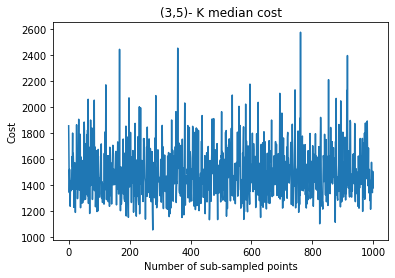

In [22]:

plt.plot(iter_no,  kmed) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Cost") 
title = "(" + str(p)+ "," + str(q) +")" + "- K median cost";
plt.title(title)
plt.show() 

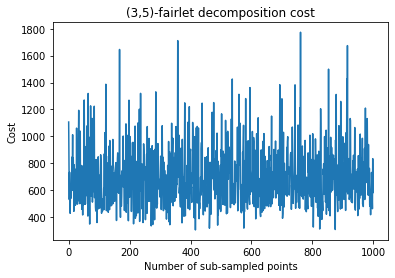

In [23]:

plt.plot(iter_no,  fcost) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Cost") 
title = "(" + str(p)+ "," + str(q) +")" + "-fairlet decomposition cost";
plt.title(title)
plt.show() 

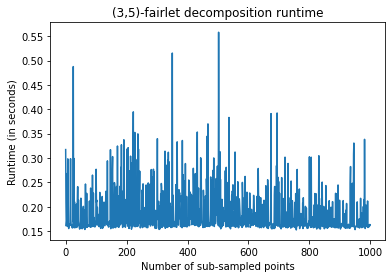

In [24]:

plt.plot(iter_no,  fTime) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Runtime (in seconds)") 
title = "(" + str(p)+ "," + str(q) +")" + "-fairlet decomposition runtime";
plt.title(title)
plt.show() 

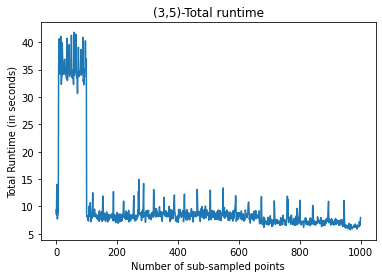

In [25]:

plt.plot(iter_no,  tTime) 
plt.xlabel("Number of sub-sampled points") 
plt.ylabel("Total Runtime (in seconds)") 
title = "(" + str(p)+ "," + str(q) +")" + "-Total runtime";
plt.title(title)
plt.show() 

In [26]:

print("Kmedian cost\n")
print(kmed)

print("Fairlet Decomp cost\n")
print(fcost)

print("Fairlet Runtime\n")
print(fTime)

print("TOtal runtime\n")
print(tTime)

Kmedian cost

[1855.60649409 1550.52376743 1344.20792106 1521.20839366 1361.28440932
 1239.23299382 1428.59747361 1356.49424788 1377.63562838 1425.48373574
 1462.47502328 1619.63349584 1544.09728323 1799.98863961 1367.56489279
 1644.61290784 1564.71227566 1230.9067704  1549.88364525 1485.6002575
 1572.63397765 1512.66696444 1192.04485361 1486.57071624 1371.08680961
 1415.1360306  1863.57993933 1460.65916609 1523.31917003 1297.27582379
 1380.39671642 1409.33859673 1712.82680844 1905.82086509 1413.71788318
 1363.50043832 1408.8908742  1425.57412905 1790.6358734  1227.67454597
 1617.43293728 1550.49528892 1594.2771703  1262.6508917  1410.98867277
 1455.0167534  1266.21336252 1384.01162999 1590.44688952 1284.97432255
 1790.77340582 1884.30333842 1765.84945793 1490.0467404  1670.88137635
 1292.34756638 1379.89663911 1719.50305591 1328.62727654 1661.17921359
 1788.66245648 1562.98199083 1823.00762918 1318.65792931 2058.74668078
 1260.85374148 1587.97153359 1691.66791766 1414.87198124 1183.71

In [27]:
print("Minimum K-Median cost  "+str(min(kmed)))
print("Minimum Fairlet cost  "+str(min(fcost)))
print("Minimum Fairlet RUntime  "+str(min(fTime)))
print("Minimum TOtal RUntime  "+str(min(tTime)))

Minimum K-Median cost  1057.7490262102644
Minimum Fairlet cost  305.19197924006045
Minimum Fairlet RUntime  0.1525726318359375
Minimum TOtal RUntime  5.714069843292236
